In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy

import torch
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import Subset, Dataset, DataLoader
import torch.nn.functional as F
from torch import nn
import torch.optim as optim


# Load MNIST data

In [2]:
root = '/home/justin_pyron/pyron/python_code/datasets/'
train_set = MNIST(root, train=True, transform=transforms.ToTensor(), download=True)
test_set = MNIST(root, train=False, transform=transforms.ToTensor(), download=True)

# Make Autoencoder class

Note: image input shape: (1,28,28)

In [3]:
class Autoencoder(nn.Module):
    
    def __init__(self, embedding_dim):
        '''
        Arguments
        ---------
        embedding_dim : int
            The dimension of the embedding space
        '''
        super().__init__()
        self.embedding_dim = embedding_dim
        
        # Encoder
        self.E_bn1 = nn.BatchNorm2d(num_features=1)
        self.E_conv1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=3, stride=2, padding=1)
        self.E_conv2 = nn.Conv2d(in_channels=20, out_channels=40, kernel_size=3, stride=2, padding=1)
        self.E_bn2 = nn.BatchNorm2d(num_features=40)
        self.E_conv3 = nn.Conv2d(in_channels=40, out_channels=80, kernel_size=3, stride=2, padding=0)
        self.E_conv4 = nn.Conv2d(in_channels=80, out_channels=160, kernel_size=3, stride=1, padding=0)
        self.E_linear = nn.Linear(in_features=160, out_features=embedding_dim)
        
        # Decoder
        self.D_linear = nn.Linear(in_features=embedding_dim, out_features=160)
        self.D_bn1 = nn.BatchNorm2d(num_features=160)
        self.D_conv4 = nn.ConvTranspose2d(in_channels=160, out_channels=80, kernel_size=3, stride=1, padding=0)
        self.D_conv3 = nn.ConvTranspose2d(in_channels=80, out_channels=40, kernel_size=3, stride=2, padding=0)
        self.D_bn2 = nn.BatchNorm2d(num_features=40)
        self.D_conv2 = nn.ConvTranspose2d(in_channels=40, out_channels=20, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.D_conv1 = nn.ConvTranspose2d(in_channels=20, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1)
        
            
    def encode(self, x):
        '''
        Map input image to an embedding vector
        
        The image spatial dimension is sequentially
        reduced according to: 28 > 14 > 7 > 4 > 1
        '''
        x = self.E_bn1(x)
        x = F.relu(self.E_conv1(x))
        x = F.relu(self.E_conv2(x))
        x = self.E_bn2(x)
        x = F.relu(self.E_conv3(x))
        x = F.relu(self.E_conv4(x))
        
        x = x.squeeze(dim=3).squeeze(dim=2)
        x = self.E_linear(x)
        
        return x
    
    
    def decode(self, x):
        '''
        Map embedding vector to a reconstructed image
        '''
        
        x = self.D_linear(x)
        x = x.unsqueeze(2).unsqueeze(3)
        
        x = self.D_bn1(x)
        x = F.relu(self.D_conv4(x))
        x = F.relu(self.D_conv3(x))
        x = self.D_bn2(x)
        x = F.relu(self.D_conv2(x))
        x = self.D_conv1(x)
        
        x = torch.sigmoid(x)
        
        return x
    
    
    def forward(self, x):
        code = self.encode(x)
        x_reconstructed = self.decode(code)
        
        return x_reconstructed, code 
    

# Train autoencoder


In [4]:
batch_size = 250
loader_train = DataLoader(train_set, batch_size, shuffle=True)
loader_test = DataLoader(test_set, batch_size, shuffle=True)


In [5]:
lr = 4e-5
weight_decay = 1e-4
code_penalty = 1e-4

model = Autoencoder(embedding_dim=10)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [6]:
loss_dict = {'train': list(), 'test': list()}
model_list = [copy.deepcopy(model)]


In [7]:
n_epoch = 25

start = time.time()
for epoch in tqdm(range(n_epoch)):

    # Train set
    # =========
    L = list()
    for (x,y) in loader_train:
        model.train()
        out, code = model(x)
        loss = F.mse_loss(out, x) + code_penalty*torch.norm(code, p=2, dim=1).mean()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        L.append(loss.item())
    loss_dict['train'].append(L)

    # Test set
    # =========
    L = list()
    for (x,y) in loader_test:
        with torch.no_grad():
            model.eval()
            out, code = model(x)
            loss = F.mse_loss(out, x) + code_penalty*torch.norm(code, p=2, dim=1).mean()
            L.append(loss.item())
    loss_dict['test'].append(L)
    model_list.append(copy.deepcopy(model)) # append in eval model

print('Complete. Time elapsed (min): {:.1f}'.format((time.time() - start)/60))

100%|██████████| 25/25 [16:45<00:00, 40.20s/it]

Complete. Time elapsed (min): 16.8


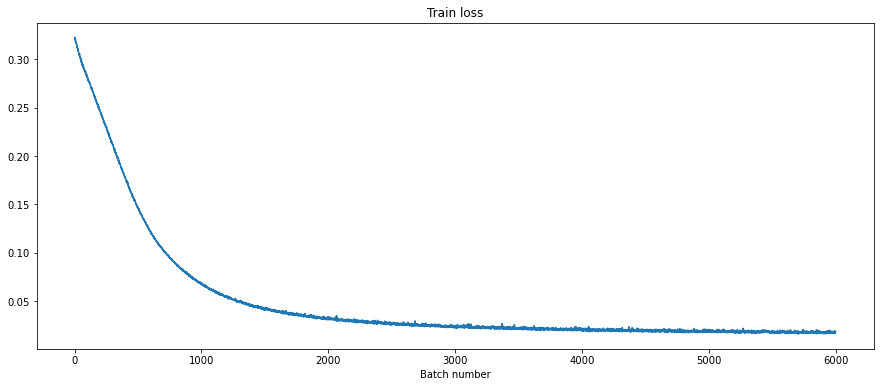

In [8]:
# train loss across batches
plt.figure(figsize=(15,6))
plt.plot(np.array(loss_dict['train']).flatten())
plt.xlabel('Batch number')
plt.title('Train loss')
plt.show()


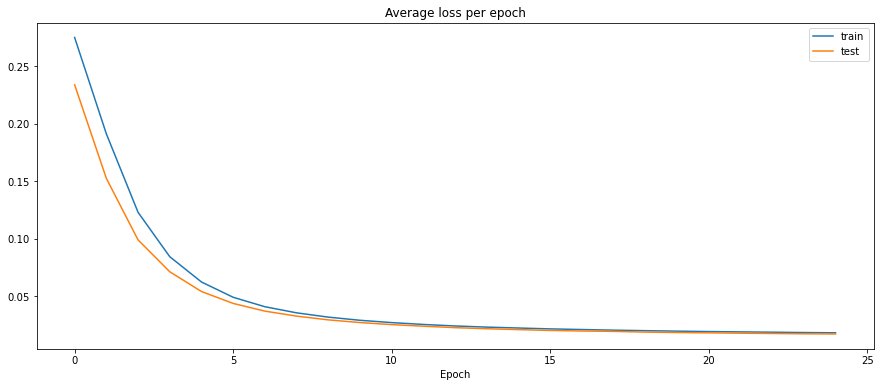

In [9]:
# train, test loss across epochs
plt.figure(figsize=(15,6))
plt.plot([np.array(x).mean() for x in loss_dict['train']], label='train')
plt.plot([np.array(x).mean() for x in loss_dict['test']], label='test')
plt.xlabel('Epoch')
plt.legend()
plt.title('Average loss per epoch')
plt.show()


### Randomly sample an input and visualize reconstruction

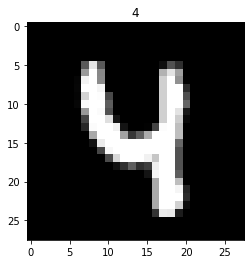

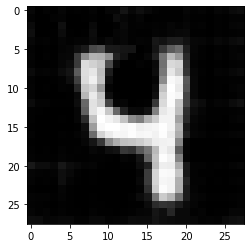

In [13]:
sample_x, sample_y = test_set[np.random.randint(len(test_set))] # a single example

with torch.no_grad():
    model.eval()
    out, code = model(sample_x.unsqueeze(0))
    
plt.imshow(sample_x.squeeze(), cmap='gray')
plt.title(sample_y)
plt.show()
plt.imshow(out.squeeze(), cmap='gray')
plt.show()


### Plot decoder output when fed random inputs

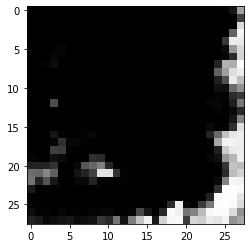

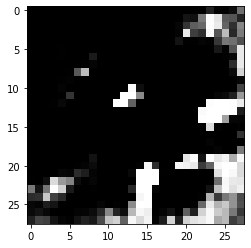

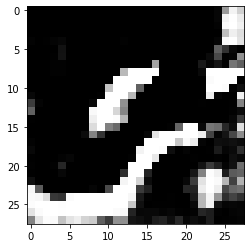

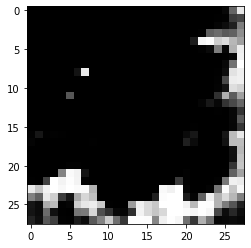

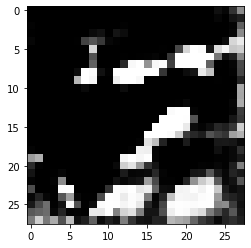

In [24]:
def decode_random(model):
    '''
    Randomly sample a vector from the
    embedding space, decode it, and
    plot the output
    '''
    code_random = torch.randn((1,model.embedding_dim))
    with torch.no_grad():
        out = model.decode(code_random)
    plt.imshow(out.squeeze(), cmap='gray')
    plt.show()
    
for i in range(5):
    decode_random(model)
    

### Visualize model reconstruction performance over time

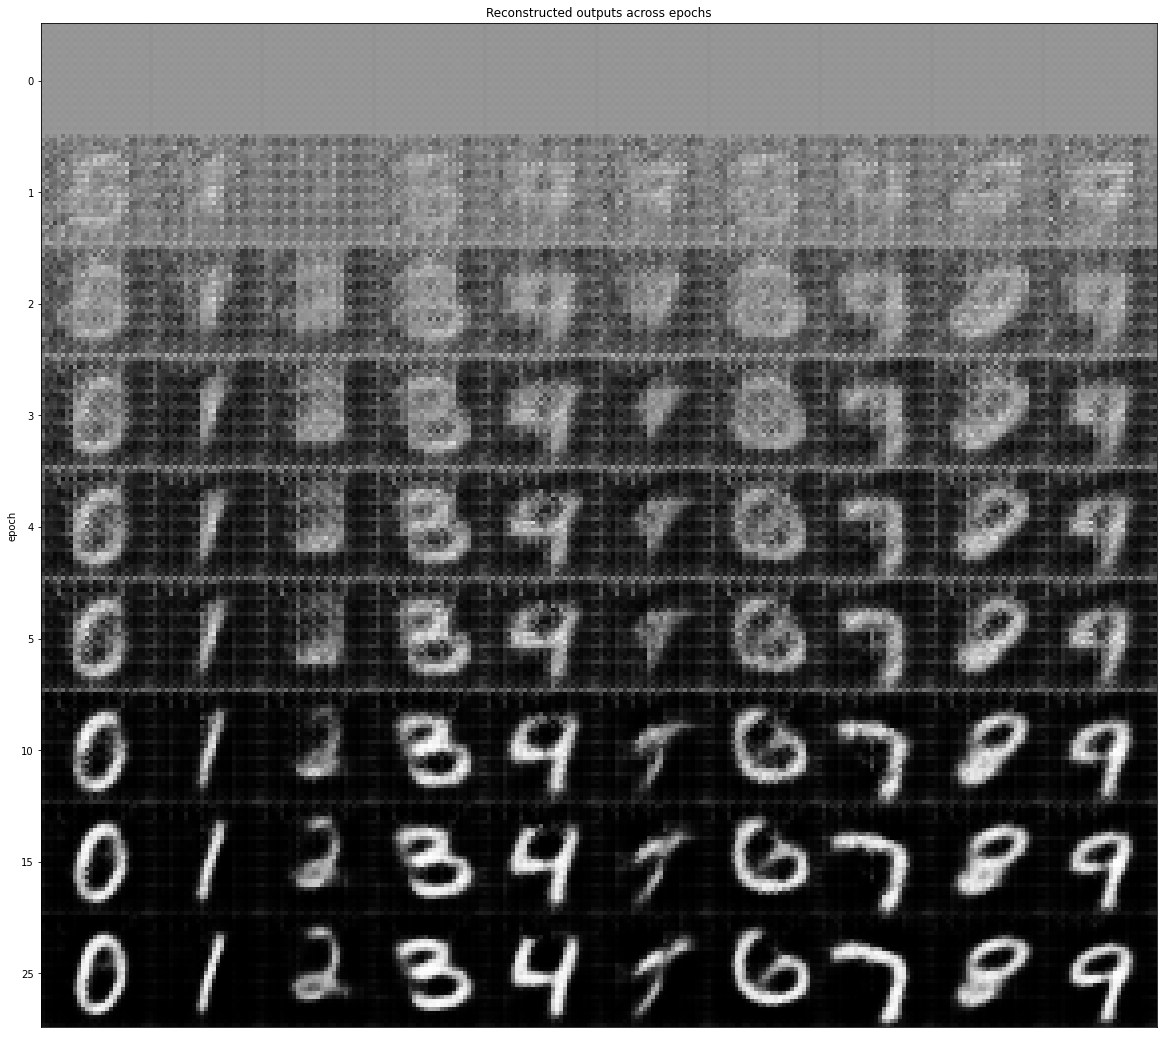

In [19]:
idx = dict()
i = 0
while len(idx) < 10:
    x,label = test_set[i]
    idx[label] = i
    i += 1
examples = [test_set[idx[i]][0] for i in range(10)]

for m in model_list:
    m.eval()
with torch.no_grad():
    epochs = [0,1,2,3,4,5,10,15,25]
    output = [[model_list[i](x.unsqueeze(0))[0].squeeze().squeeze() for x in examples] for i in epochs]
merged = np.vstack([np.hstack(epoch) for epoch in output])

plt.figure(figsize=(2*10, 2*n_epoch))
plt.imshow(merged, cmap='gray')
plt.xticks([])
plt.yticks([14 + 28*i for i in range(len(epochs))], epochs)
plt.ylabel('epoch')
plt.title('Reconstructed outputs across epochs')
plt.show()
